# Exploratory data analysis 1

This notebook demonstrates that the ground truth turning angles tend to have more extreme values with higher speeds and with manual driving.

In [1]:
%load_ext autoreload
%autoreload 2
import os
# do we have the correct env loaded?
assert 'donkey2' == os.environ['CONDA_DEFAULT_ENV'], os.environ['CONDA_DEFAULT_ENV']

## Are the ground truth turning angles more extreme for with higher speeds?
### Load ground truth angles for fast auto and slow manual driving

In [15]:
import numpy as np
fast_auto_ground_truth = np.loadtxt('open-loop-results/daytime-slow-3d-model-daytime-fast-data-prediction-and-ground-truth.csv.gz')[:, 1]
slow_manual_ground_truth = np.loadtxt('open-loop-results/daytime-fast-3d-model-daytime-slow-data-prediction-and-ground-truth.csv.gz')[:, 1]

### How many data points are there?


In [16]:
len(fast_auto_ground_truth), len(slow_manual_ground_truth)

(20771, 31361)

## Demonstrate that manual driving has more extreme ground truth turning angles even with slower speed.

In [17]:
from matplotlib import pyplot as plt

def plot_all(name, ground_truths):
    plt.figure()
    hist, bins, _ = plt.hist(ground_truths.values(), bins=15, density=True)
    plt.title(name)
    plt.legend(ground_truths.keys())
    plt.xlabel('angle')
    plt.ylabel('count')
    plt.grid()
    plt.show()
    return hist

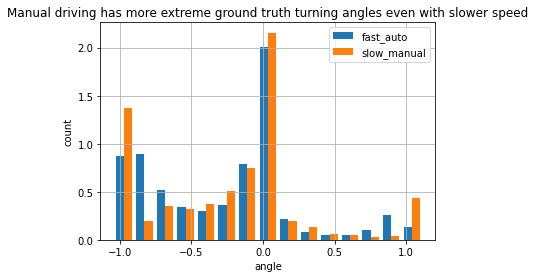

In [18]:
hist = plot_all('Manual driving has more extreme ground truth turning angles even with slower speed', dict(fast_auto=fast_auto_ground_truth, slow_manual=slow_manual_ground_truth))

## Demonstrate that fast driving has more extreme ground truth turning angles


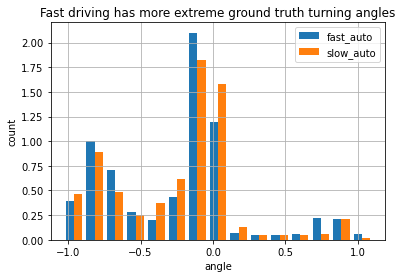

In [19]:
fast_nighttime_auto_ground_truth = np.loadtxt('open-loop-results/nighttime-fast-auto-3d-model-nighttime-fast-auto-data-prediction-and-ground-truth.csv.gz')[:, 1]
slow_nighttime_auto_ground_truth_ = np.loadtxt('open-loop-results/nighttime-fast-auto-3d-model-nighttime-slow-auto-data-prediction-and-ground-truth.csv.gz')[:, 1]

hist = plot_all('Fast driving has more extreme ground truth turning angles', dict(fast_auto=fast_nighttime_auto_ground_truth, slow_auto=slow_nighttime_auto_ground_truth_))
